#### Train RL model

train the model in the simualated environment. During training evaluation data is collected to follow the training.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
from pathlib import Path
from stable_baselines3 import A2C

# Find the root directory by traversing up the directory tree
def find_project_root(current_path):
    if os.path.exists(os.path.join(current_path, "README.md")):
        return current_path
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Project root not found.")
    return find_project_root(parent_path)


current_dir = os.getcwd()
project_root = find_project_root(current_dir)
sys.path.append(str(project_root))
print(f"Project root: {project_root}")

# flake8: noqa  # Disable Flake8 for the following block
import gymnasium as gym
from src.models.bank_env import BankEnv
from src.visualization import visualize
import src.models.train as train
from src.tests import test_bankmodel_a2c_train as tests
from src.data.definitions import MODEL_PATH, TENSORBOARD_LOGS
from src.models.evaluate import evaluate_policy

Project root: f:\OneDrive\Documents\GitHub\rl-alm


f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (None)/charset_normalizer (3.3.0) doesn't match a supported version!
  warnings.warn(


##### First test - just take a random walk in the environment. 

Each episode consists of 60 months. Each timestep interest rates and swap rates are simulated and the bank enters into new mortgages.  
Each month the actor needs to decide on the funding strategy to fund the bank. 

In [2]:
env_id = "bank-v3"
gym.register(id=env_id, entry_point=BankEnv, max_episode_steps=60)


In [3]:
# Random walk in the environment
tests.random_walk(env_id)

2023-10-16 10:46:11.117 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-10-16 10:46:12.571 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
steps: 60, score: -11836


Define the model. For the initial model we use the A2C model. 

In [4]:
env = gym.make(env_id, render_mode="human")

# Define a Lineair Learning Rate Scheduler
def linear_schedule(initial_value: float):
    """Linear learning rate schedule."""

    def func(progress_remaining: float) -> float:
        """Progress will decrease from 1 (beginning) to 0."""
        return progress_remaining * initial_value

    return func

initial_lr = 0.001
n_steps = 60
model_name = 'A2C'
ent_coef= 0.001
# policy_kwargs = dict(
#    net_arch=[128, 128]
# )


model = A2C(
        "MultiInputPolicy",        
        env,
        device="cpu",
        tensorboard_log=TENSORBOARD_LOGS,
        verbose=0,
        n_steps=n_steps,
        learning_rate=linear_schedule(initial_lr),
        ent_coef=ent_coef,
        # policy_kwargs = policy_kwargs,        
    )

2023-10-16 10:46:24.196 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-10-16 10:46:25.430 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))


##### Train the model in the environment and save it

Model name: A2C, Steps: 60000, Mean: 885.867, IQR: 324.0, CVaR: -2221.5


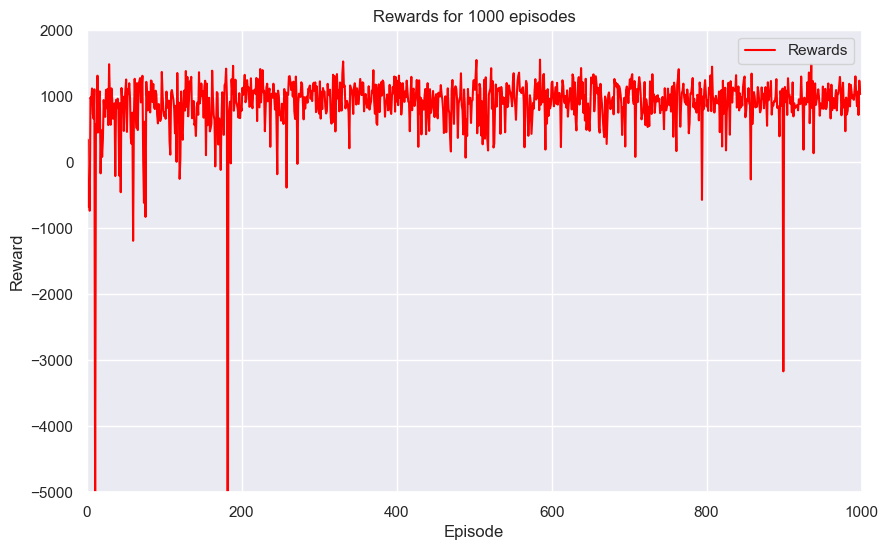

In [5]:
steps = 600_000
 
model, mean, episode_iqr, episode_cvar, episode_rewards = train.train( model, env, total_timesteps=steps, conf_level=0.95, tb_log_name= TENSORBOARD_LOGS)
modelpath = Path(    
        MODEL_PATH,
        model_name + "_" + str(steps) + ".zip",
    )
model.save(modelpath)
print(f"Model name: {model_name}, Steps: {steps}, Mean: {mean}, IQR: {episode_iqr}, CVaR: {episode_cvar}")
visualize.plot_rewards(episode_rewards, interpolate_line=False, ylim=(-5000,2000))

In [6]:
print(model.policy)

MultiInputActorCriticPolicy(
  (features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (liquidity): Flatten(start_dim=1, end_dim=-1)
      (cashflows): Flatten(start_dim=1, end_dim=-1)
      (swap_rates): Flatten(start_dim=1, end_dim=-1)
      (bank_rates): Flatten(start_dim=1, end_dim=-1)
      (features): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (pi_features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (liquidity): Flatten(start_dim=1, end_dim=-1)
      (cashflows): Flatten(start_dim=1, end_dim=-1)
      (swap_rates): Flatten(start_dim=1, end_dim=-1)
      (bank_rates): Flatten(start_dim=1, end_dim=-1)
      (features): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (vf_features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (liquidity): Flatten(start_dim=1, end_dim=-1)
      (cashflows): Flatten(start_dim=1, end_dim=-1)
      (swap_rates): Flatten(start_dim=1, end_dim=-1)
      (bank_rates): Flatten(start_dim=1, end_di

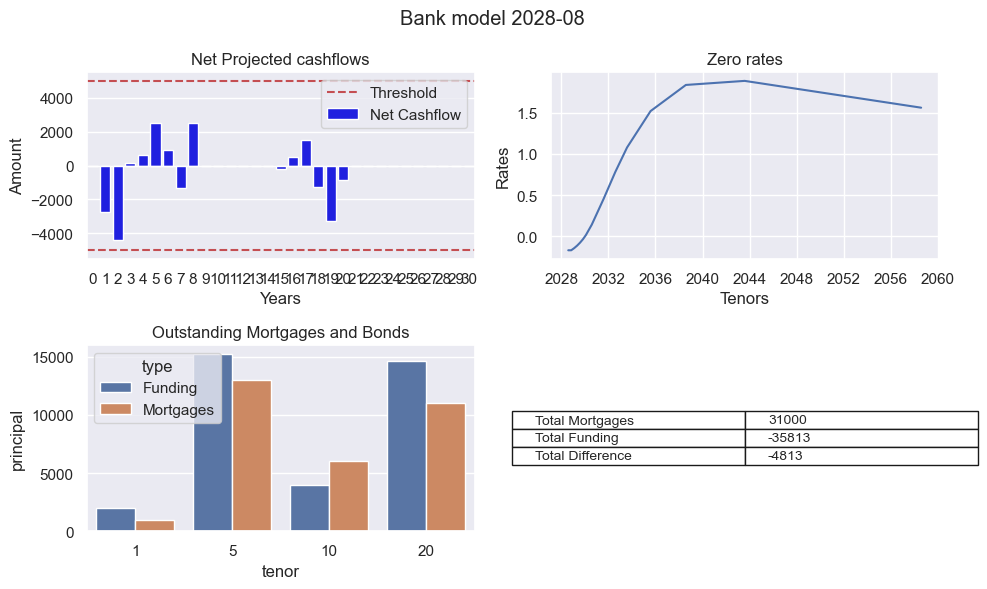

final score:  784


,timestep,reward,risk_penalty,liquidity_penalty,liquidity,nii,income,funding_cost,total_funding,total_mortgages
0,1,0,0,0,27.320921,0,0.000000,-0.053725,-27,0
1,2,0,0,0,137.293129,0,0.000000,-0.291489,-136,0
2,3,0,0,0,363.735405,0,0.000000,-0.715257,-362,0
3,4,-1,0,0,579.899132,-1,0.000000,-1.184185,-578,0
4,5,-1,0,0,579.899132,-1,0.000000,-1.184185,-578,0
5,6,-3,0,0,1579.899132,-3,0.000000,-3.366954,-1578,0
6,7,-3,0,0,2345.736428,-3,3.114011,-6.728836,-3342,1000
7,8,-2,0,0,2698.436348,-2,6.532946,-9.106793,-4694,2000
8,9,0,0,0,1698.436348,0,9.395468,-9.106793,-4694,3000
9,10,2,0,0,1492.825386,2,12.347413,-10.324593,-5488,4000


In [7]:
def show_model(env, model) -> int:
    """Show the model in the environment"""        
    # env.set_render_output(modelpath.stem)
    obs, info = env.reset()
    score = 0
    terminated = False
    truncated = False
    # env.set_render_output('A2C')

    while not terminated and not truncated:
        action, _state = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        score = score + reward
        # env.render()
        df = env.list_model()    
    env.plot()
    env.close()    
    return score, df

score, df = show_model(env, model)
print ('final score: ', score)
df.head(60)

In [ ]:
mean_reward, irq, es, rewards = evaluate_policy(model, env, n_eval_episodes=500)

In [ ]:
print(f"number of episodes = {len(rewards)}, mean_reward={mean_reward:.2f} Expected Shortfall={es:.2f} Interquartile Range={irq:.2f}")

In [ ]:
visualize.plot_rewards(rewards, interpolate_line=False)